In [63]:
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from collections import defaultdict
import matplotlib as mpl

mpl.rcParams['figure.figsize'] = (6,6)
mpl.rcParams['figure.dpi'] = 100
mpl.rcParams["image.origin"] = 'lower'

In [64]:
samples_dir = "/eos/home-d/dmapelli/public/latino/Full2017v6_200121_v1"
cut = "lowen_looseVBS"

In [65]:
os.listdir(os.path.join(samples_dir, cut))

['DY_part1.pkl',
 'DY_part2.pkl',
 'DY_part3.pkl',
 'VBS_part1.pkl',
 'Wjets_part1.pkl',
 'background_part1.pkl',
 'models',
 'top_part1.pkl']

In [66]:
samples = {}
for sname in ["VBS", "background"]:
    files = [f for f in os.listdir(os.path.join(samples_dir, cut)) if sname in f]
    for file in files:
        s = pickle.load(open(os.path.join(samples_dir, cut, file), "rb"))
        sname = file.split("_part")[0]
        s.rename(columns=lambda c: c.split(cut+"_")[1] if cut in c else c, inplace=True)

        if sname in samples:
            samples[sname] = pd.concat([samples[sname], s], ignore_index=True)
        else:
            samples[sname] = s


In [67]:
for s, df in samples.items():
    print(f"Sample name {s:10}, nsamples: {len(df):10},   XS total: {(df.XSWeight*df.weight*df.puWeight).sum()*41:15}")

Sample name VBS       , nsamples:     123434,   XS total: 542.9917437296729
Sample name background, nsamples:     522170,   XS total: 176608.83388072244


In [68]:
samples["VBS"].columns

Index(['weight', 'XSWeight', 'Lepton_RecoSF', 'LepWPWeight', 'puWeight',
       'TriggerEffWeight_1l', 'btagSF', 'PrefireWeight', 'events', 'Lepton_pt',
       'Lepton_eta', 'Lepton_phi', 'Lepton_flavour', 'PuppiMET',
       'PuppiMET_phi', 'MET_pt', 'recoMET_pz', 'nJets', 'N_jets_central',
       'N_jets_forward', 'mjj_vbs', 'deltaeta_vbs', 'deltaphi_vbs',
       'vbs_etaprod', 'vbs_0_pt', 'vbs_1_pt', 'vbs_0_eta', 'vbs_1_eta',
       'vbs_0_phi', 'vbs_1_phi', 'vbs_index_0', 'vbs_index_1', 'mjj_vjet',
       'vjet_0_pt', 'vjet_1_pt', 'vjet_0_eta', 'vjet_1_eta', 'vjet_0_phi',
       'vjet_1_phi', 'vjet_index_0', 'vjet_index_1', 'Zvjets_0', 'Zlep',
       'Asym_vbs', 'Asym_vjet', 'Mw_lep_reco', 'Mtw_lep', 'w_lep_pt', 'Mww',
       'R_ww', 'R_mw', 'A_ww', 'Centr_vbs', 'Centr_ww', 'nvtx', 'qgl'],
      dtype='object')

In [69]:
## check if there is any event with weight == 0.0
for sname in ["VBS", "background"]:
    print(samples[sname][ samples[sname]["weight"] == 0.0 ])

Empty DataFrame
Columns: [weight, XSWeight, Lepton_RecoSF, LepWPWeight, puWeight, TriggerEffWeight_1l, btagSF, PrefireWeight, events, Lepton_pt, Lepton_eta, Lepton_phi, Lepton_flavour, PuppiMET, PuppiMET_phi, MET_pt, recoMET_pz, nJets, N_jets_central, N_jets_forward, mjj_vbs, deltaeta_vbs, deltaphi_vbs, vbs_etaprod, vbs_0_pt, vbs_1_pt, vbs_0_eta, vbs_1_eta, vbs_0_phi, vbs_1_phi, vbs_index_0, vbs_index_1, mjj_vjet, vjet_0_pt, vjet_1_pt, vjet_0_eta, vjet_1_eta, vjet_0_phi, vjet_1_phi, vjet_index_0, vjet_index_1, Zvjets_0, Zlep, Asym_vbs, Asym_vjet, Mw_lep_reco, Mtw_lep, w_lep_pt, Mww, R_ww, R_mw, A_ww, Centr_vbs, Centr_ww, nvtx, qgl]
Index: []

[0 rows x 56 columns]
Empty DataFrame
Columns: [weight, XSWeight, Lepton_RecoSF, LepWPWeight, puWeight, TriggerEffWeight_1l, btagSF, PrefireWeight, events, Lepton_pt, Lepton_eta, Lepton_phi, Lepton_flavour, PuppiMET, PuppiMET_phi, MET_pt, recoMET_pz, nJets, N_jets_central, N_jets_forward, mjj_vbs, deltaeta_vbs, deltaphi_vbs, vbs_etaprod, vbs_0_pt,

## Samples preparation for NN

In [70]:
## using 
## source /cvmfs/sft.cern.ch/lcg/views/LCG_96python3/x86_64-centos7-gcc8-opt/setup.sh
#!pip3 install --user imbalanced-learn==0.5

In [71]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler, QuantileTransformer
from sklearn.model_selection import train_test_split
from imblearn.keras import balanced_batch_generator
from imblearn.over_sampling import RandomOverSampler
import tensorflow
import keras
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from keras.datasets import mnist
from keras.models import Model, Sequential
from keras.layers import Dense, Conv2D, Dropout, BatchNormalization, Input, Reshape, Flatten, Deconvolution2D, Conv2DTranspose, MaxPooling2D, UpSampling2D, Lambda
from keras.layers.advanced_activations import LeakyReLU
from keras.optimizers import adam
from keras import backend as K
from keras.callbacks import *

In [74]:
# cols = ["mjj_vbs", "mjj_vjet", "deltaeta_vbs", "vbs_0_pt", "vbs_1_pt", "vbs_0_eta", "vbs_1_eta", "Lepton_pt", "Lepton_eta", "Lepton_flavour"]
cols = ["mjj_vbs", 
        "vbs_0_pt", "vbs_1_pt", "vbs_0_eta", "vbs_1_eta", 
        "vbs_index_0", "vbs_index_1",
        "deltaeta_vbs", "deltaphi_vbs", 
        "mjj_vjet", 
        "vjet_0_pt", "vjet_1_pt", "vjet_0_eta", "vjet_1_eta", 
        "vjet_index_0", "vjet_index_1", 
        "Lepton_pt", "Lepton_eta", "Lepton_flavour",
        "PuppiMET", 
        "nJets", "N_jets_central", "N_jets_forward", 
        "Zvjets_0", "Zlep", 
        "Asym_vbs", "Asym_vjet", 
        "A_ww", 
        "Mw_lep_reco", "Mtw_lep", "w_lep_pt", "Mww", 
        "R_ww", "R_mw", 
        "Centr_vbs", "Centr_ww",
       ]

In [75]:
X_sig = samples["VBS"][cols].values
X_bkg = samples["background"][cols].values
Y_sig = np.ones(len(X_sig))
Y_bkg = np.zeros(len(X_bkg))
W_sig = samples["VBS"]["weight"].values
W_bkg = samples["background"]["weight"].values

Stack arrays in one only ntuple

In [76]:
X = np.vstack([X_sig, X_bkg])
Y = np.hstack([Y_sig, Y_bkg])
W = np.hstack([W_sig, W_bkg])

In [77]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
model_dir = samples_dir + "/" + cut + "/models/"
import os 
os.makedirs(model_dir, exist_ok=True)
pickle.dump(scaler, open(f"{model_dir}/scaler_model_v0.pkl", "wb"))

In [78]:
den=True

In [80]:
#_ = plt.hist(X[Y==0][:,7], bins=100, density=den, alpha=0.5)
#_ = plt.hist(X[Y==1][:,7], bins=100, color="r", density=den, alpha=0.5)
#plt.yscale("log")
#plt.scatter(X_scaled[Y==1][:,4], X_scaled[Y==1][:,1], c="b")

##  Balancing
Let's give 25% to validation (validation during training + test). 
The validation is then split in 50%-50% for training validation and final result

In [81]:
X_train, X_temp, y_train, y_temp, W_train, W_temp = train_test_split(X_scaled, Y,      W,      test_size=0.25)
X_val,   X_test, y_val,   y_test, W_val,   W_test = train_test_split(X_temp,   y_temp, W_temp, test_size=0.5)

Create generators to balance signal and background

In [82]:
training_generator,   steps_per_epoch_train = balanced_batch_generator(X_train, y_train, W_train, batch_size=1024, sampler=RandomOverSampler())
validation_generator, steps_per_epoch_val   = balanced_batch_generator(X_val,   y_val,   W_val,   batch_size=1024, sampler=RandomOverSampler())

## Keras model

In [92]:
model = Sequential()
model.add(Dense(100, input_dim=X_train.shape[1], activation="relu"))
model.add(Dropout(0.3))
model.add(Dense(80, activation="relu"))
model.add(Dropout(0.3))
model.add(Dense(50, activation="relu"))
model.add(Dropout(0.3))
model.add(Dense(1, activation="sigmoid"))

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.summary()

W0121 14:14:24.892412 140559107684160 deprecation.py:506] From /cvmfs/sft.cern.ch/lcg/views/LCG_96python3/x86_64-centos7-gcc8-opt/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:3445: calling dropout (from tensorflow.python.ops.nn_ops) with keep_prob is deprecated and will be removed in a future version.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_10 (Dense)             (None, 100)               3700      
_________________________________________________________________
dropout_1 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_11 (Dense)             (None, 80)                8080      
_________________________________________________________________
dropout_2 (Dropout)          (None, 80)                0         
_________________________________________________________________
dense_12 (Dense)             (None, 50)                4050      
_________________________________________________________________
dropout_3 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_13 (Dense)             (None, 1)                 51        
Total para

In [93]:
auto_save = ModelCheckpoint("../models/model12_balanced_100_50.hd5", monitor='val_loss', 
                    verbose=1, save_best_only=True, save_weights_only=False, 
                    mode='auto', period=5)

early_stop = EarlyStopping(monitor='val_loss', min_delta=0.0001, 
                            patience=10, verbose=1)

history = model.fit_generator(
            training_generator, 
            epochs=100,
            steps_per_epoch=steps_per_epoch_train, 
            validation_data = validation_generator, 
            validation_steps = steps_per_epoch_val,
            callbacks = []
            )

Epoch 1/100
764/764 [==============================] - 6s 8ms/step - loss: 0.3992 - acc: 0.7520 - val_loss: 0.3725 - val_acc: 0.7733
Epoch 2/100
764/764 [==============================] - 5s 7ms/step - loss: 0.3782 - acc: 0.7696 - val_loss: 0.3670 - val_acc: 0.7778
Epoch 3/100
764/764 [==============================] - 6s 8ms/step - loss: 0.3733 - acc: 0.7743 - val_loss: 0.3650 - val_acc: 0.7812
Epoch 4/100
764/764 [==============================] - 5s 7ms/step - loss: 0.3703 - acc: 0.7764 - val_loss: 0.3630 - val_acc: 0.7819
Epoch 5/100
764/764 [==============================] - 5s 6ms/step - loss: 0.3681 - acc: 0.7785 - val_loss: 0.3614 - val_acc: 0.7830
Epoch 6/100
764/764 [==============================] - 5s 7ms/step - loss: 0.3668 - acc: 0.7798 - val_loss: 0.3612 - val_acc: 0.7834
Epoch 7/100
764/764 [==============================] - 5s 6ms/step - loss: 0.3654 - acc: 0.7808 - val_loss: 0.3608 - val_acc: 0.7823
Epoch 8/100
764/764 [==============================] - 5s 7ms/step - 

764/764 [==============================] - 5s 7ms/step - loss: 0.3562 - acc: 0.7875 - val_loss: 0.3596 - val_acc: 0.7865
Epoch 63/100
764/764 [==============================] - 5s 7ms/step - loss: 0.3561 - acc: 0.7876 - val_loss: 0.3597 - val_acc: 0.7864
Epoch 64/100
764/764 [==============================] - 5s 7ms/step - loss: 0.3558 - acc: 0.7875 - val_loss: 0.3600 - val_acc: 0.7860
Epoch 65/100
764/764 [==============================] - 6s 7ms/step - loss: 0.3559 - acc: 0.7877 - val_loss: 0.3606 - val_acc: 0.7857
Epoch 66/100
764/764 [==============================] - 5s 7ms/step - loss: 0.3560 - acc: 0.7872 - val_loss: 0.3598 - val_acc: 0.7858
Epoch 67/100
764/764 [==============================] - 5s 7ms/step - loss: 0.3560 - acc: 0.7878 - val_loss: 0.3593 - val_acc: 0.7856
Epoch 68/100
764/764 [==============================] - 5s 7ms/step - loss: 0.3560 - acc: 0.7877 - val_loss: 0.3593 - val_acc: 0.7865
Epoch 69/100
764/764 [==============================] - 5s 7ms/step - loss:

In [94]:
# Evalutation
print(">>> Computing AUC...")

from sklearn.metrics import roc_auc_score, roc_curve

pred = model.predict(X_test)
auc = roc_auc_score(y_test,pred)
fp, tp, th = roc_curve(y_test, pred)
print("AUC score: " + str(auc))

>>> Computing AUC...
AUC score: 0.8711258703284769


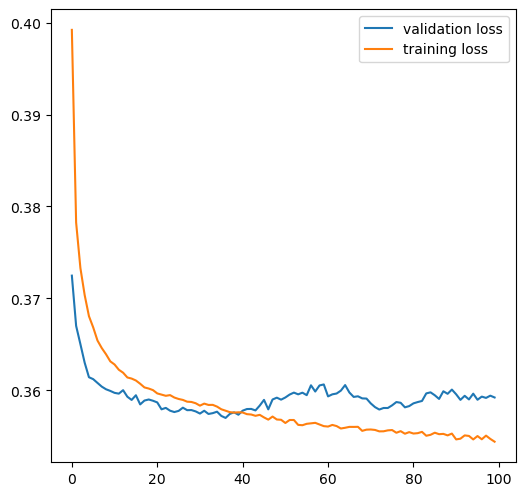

In [95]:
plt.plot(history.epoch, history.history["val_loss"], label="validation loss")
plt.plot(history.epoch, history.history["loss"], label="training loss")
plt.legend()

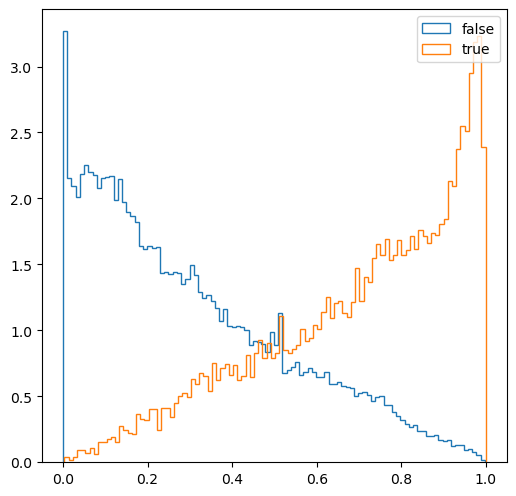

In [96]:
results = model.predict(X_test)
plt.hist(results[y_test==0], bins=100,density=True, label="false", histtype="step")
plt.hist(results[y_test==1], bins=100, density=True, label="true", histtype="step")
#plt.yscale("log")
plt.legend()

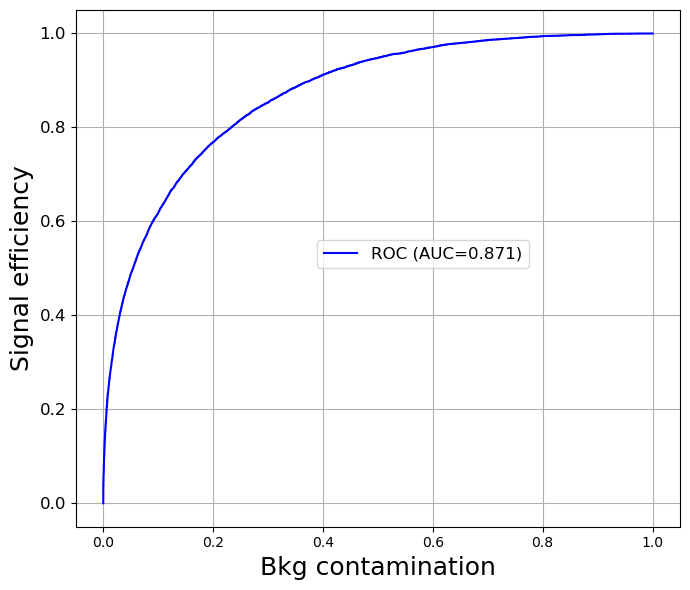

In [97]:
fig, ax1 = plt.subplots(figsize=(7,6), dpi=100)

ax1.plot(fp, tp, label=f"ROC (AUC={auc:.3f})", color="blue")

ax1.set_xlabel("Bkg contamination", fontsize=18)
ax1.set_ylabel("Signal efficiency", fontsize=18)

#ax1.plot([0,1],[1,1],"b--")
ax1.tick_params("y",labelsize="large")

ax1.grid()

ax1.legend(loc=(0.4, 0.5), fontsize="large")

fig.tight_layout()